Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists('../data/{}'.format(filename)):
    filename, _ = urlretrieve(url + filename, '../data/{}'.format(filename))
  statinfo = os.stat('../data/{}'.format(filename))
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [19]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data('../data/{}'.format(filename))
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [20]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [21]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [22]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [23]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [24]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [25]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.297665 learning rate: 10.000000
Minibatch perplexity: 27.05
cjpu  fiaslo ytokuanhbwydipurh  rswf cm  enazcakehifr saxdolkezfaezi vri sstiilg
dqhjthjwsenjslepelmdih aahllrgoldmauqnk naumektonfqmwkgsaaoprnuuuj nigkdto d   q
p bis eed hmrv aifelcugf rraeotd i etebpwputiin cv  wcg etttviragk d  te yiy l e
jdztim gjlxqwi cjshlkazadizmcxkufeeovfgcra t rd ocngckej lelnabsdthdxeem roziudq
etoa tn n   npnnsldyeris adtquiet enjcegeyg dztntdmnfutum d w in cuveizbi t  m n
Validation set perplexity: 20.19
Average loss at step 100: 2.589568 learning rate: 10.000000
Minibatch perplexity: 11.16
Validation set perplexity: 10.50
Average loss at step 200: 2.254460 learning rate: 10.000000
Minibatch perplexity: 8.52
Validation set perplexity: 8.81
Average loss at step 300: 2.104440 learning rate: 10.000000
Minibatch perplexity: 7.57
Validation set perplexity: 8.42
Average loss at step 400: 2.014715 learning rate: 10.000000
Minibatch perplexity: 7.80
Validation set per

Validation set perplexity: 4.51
Average loss at step 4500: 1.619648 learning rate: 10.000000
Minibatch perplexity: 5.28
Validation set perplexity: 4.62
Average loss at step 4600: 1.618417 learning rate: 10.000000
Minibatch perplexity: 5.17
Validation set perplexity: 4.67
Average loss at step 4700: 1.631018 learning rate: 10.000000
Minibatch perplexity: 5.22
Validation set perplexity: 4.52
Average loss at step 4800: 1.633191 learning rate: 10.000000
Minibatch perplexity: 4.48
Validation set perplexity: 4.50
Average loss at step 4900: 1.636342 learning rate: 10.000000
Minibatch perplexity: 5.33
Validation set perplexity: 4.61
Average loss at step 5000: 1.612117 learning rate: 1.000000
Minibatch perplexity: 4.63
l in wings infigied is senting goders is five beings anvispe ontom gald couster 
dment and that him holigie mants often marrens trow he s king his dest delless o
lumin of his comes was blears was music s doraby the mules increacition is  was 
s based the earny understed one zero t

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [29]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))

  #combined f,i,c,o
  fico_x = tf.Variable(tf.truncated_normal([4, vocabulary_size, num_nodes], -0.1, 0.1))
  fico_m = tf.Variable(tf.truncated_normal([4, num_nodes, num_nodes], -0.1, 0.1))
  fico_b = tf.Variable(tf.zeros([4, 1, num_nodes]))

  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [39]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.296957 learning rate: 10.000000
Minibatch perplexity: 27.03
pzov xsrjxn t w  jvdyermbsaiebntrozticsfj   iekulwooiqefu lsxnibhdrlkuhtsbeeeodx
zec afnjrkdnd c joleco ahpi sveohh sdoc  kaze h dom wqyknveirvqn o o mniecgntess
gpigai  e tag dlevu raitmmuigsylle  nt xafncsiije i z t  hprbrukijyjdnwqifhh haf
nooheme hihc iiwd ebfre fsl prl cykgnmsv   i d n cw vm rnfysee jiio gnqmc  c d a
umygrpaisrkshrteikemeppos n moddn nlhap ggiexde anre a onnv fhrfyct bmfetbzvsq r
Validation set perplexity: 20.16
Average loss at step 100: 2.590779 learning rate: 10.000000
Minibatch perplexity: 10.37
Validation set perplexity: 10.45
Average loss at step 200: 2.245210 learning rate: 10.000000
Minibatch perplexity: 8.37
Validation set perplexity: 8.85
Average loss at step 300: 2.086749 learning rate: 10.000000
Minibatch perplexity: 8.15
Validation set perplexity: 8.31
Average loss at step 400: 2.032647 learning rate: 10.000000
Minibatch perplexity: 7.87
Validation set per

Validation set perplexity: 4.87
Average loss at step 4500: 1.636856 learning rate: 10.000000
Minibatch perplexity: 4.95
Validation set perplexity: 4.96
Average loss at step 4600: 1.625073 learning rate: 10.000000
Minibatch perplexity: 5.29
Validation set perplexity: 4.91
Average loss at step 4700: 1.625229 learning rate: 10.000000
Minibatch perplexity: 5.01
Validation set perplexity: 4.85
Average loss at step 4800: 1.608100 learning rate: 10.000000
Minibatch perplexity: 5.31
Validation set perplexity: 4.79
Average loss at step 4900: 1.621739 learning rate: 10.000000
Minibatch perplexity: 4.99
Validation set perplexity: 4.84
Average loss at step 5000: 1.613398 learning rate: 1.000000
Minibatch perplexity: 4.82
reiles sprive one one eight seven know nonb read protegoum of the bibll be the a
key intempe wo d the primal incomponences of ground by adviefred connionial or f
tain autist procacil three one one eight eeggn om visive muss the rich ame impor
s persocal public lates the drivious v

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [58]:
def build_bigram_dictionary():  
  # 26 letters + space
  all_letters = string.ascii_lowercase + " "
  bigram_list = []
  dictionary = dict()
  dic_index = 0
  for i in all_letters:
    for j in all_letters:
      dictionary[i+j] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return dictionary, reverse_dictionary 

dictionary, reverse_dictionary = build_bigram_dictionary()

print(dictionary['aa'])  
print(dictionary['sd'])  
print(dictionary['  '])  
print(reverse_dictionary[100])  
print(len(dictionary))  


0
489
728
dt
729


In [59]:
def build_dataset(text):  
  bigram_data = [a+b for a,b in zip(text[:len(text)],text[1:len(text)+1])][::2]
  data = [dictionary[i] for i in bigram_data]
  return data

data = build_dataset(text)  
print(data[:10])  
print([reverse_dictionary[i] for i in data[:10]])  

[702, 351, 461, 197, 498, 716, 467, 170, 351, 517]
[' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi', 'na', 'te']


In [60]:
import collections

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):  
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:  
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: [' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi']

with num_skips = 2 and skip_window = 1:
    batch: ['na', 'na', 'rc', 'rc', 'hi', 'hi', 'sm', 'sm']
    labels: ['rc', ' a', 'na', 'hi', 'sm', 'rc', 'hi', ' o']

with num_skips = 4 and skip_window = 2:
    batch: ['rc', 'rc', 'rc', 'rc', 'hi', 'hi', 'hi', 'hi']
    labels: ['hi', 'na', ' a', 'sm', 'sm', ' o', 'rc', 'na']


In [67]:
import math

batch_size = 128  
embedding_size = 128 # Dimension of the embedding vector.  
skip_window = 1 # How many words to consider left and right.  
num_skips = 2 # How many times to reuse an input to generate a label.  
## We pick a random validation set to sample nearest neighbors. here we limit the
## validation samples to the words that have a low numeric ID, which by
## construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.  
valid_window = 100 # Only pick dev samples in the head of the distribution.  
valid_examples = np.array(random.sample(range(valid_window), valid_size))  
num_sampled = 64 # Number of negative examples to sample.

vocabulary_size =  len(dictionary)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(
        weights = softmax_weights,
        biases = softmax_biases, 
        inputs = embed, 
        labels = train_labels, 
        num_sampled = num_sampled, 
        num_classes = vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [68]:
num_steps = 100001

with tf.Session(graph=graph) as session:  
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 3.829792
Nearest to ab: ld, yi,   , rz, yt, m , ow, gj,
Nearest to bx: iw, ch, yi, js, lr, nr, pz, jq,
Nearest to co: hp, xl, if, uy, zb, by, tt, cm,
Nearest to cq: bn, qo, wo, cf, on, kd, x , vv,
Nearest to cx: iv, tz, u , nz, zb, oe, ov, ko,
Nearest to de: yu, bh, jk, by, z , mw, qt, pr,
Nearest to cj: ml, ls, pe, wp, nb, sr, j , ks,
Nearest to cd: pd, eu, vh, jt, in, mi, xf, vn,
Nearest to bk: ti, tv, ln,  v, zi, pz, vx, w ,
Nearest to dq: qr, oj, u , gj, fr, we, kc, wt,
Nearest to dg: ee, yu, yc, ca, hr, yo, vc, ff,
Nearest to cz: we, nd, tr, tn, kv, ri, ie, da,
Nearest to ae: sj, tw, pb, aa, ff, ho, ld, oz,
Nearest to bi: vj, hf, kg, ee, xh, ux, xf, xp,
Nearest to da: md, za, bu, me, kv, az, hi, vz,
Nearest to ba:  r, ug, rx, wo, uk, bh, hh, fz,
Average loss at step 2000: 1.885980
Average loss at step 4000: 1.650657
Average loss at step 6000: 1.640954
Average loss at step 8000: 1.622027
Average loss at step 10000: 1.657214
Nearest to ab: sk, vq,

Average loss at step 82000: 1.548354
Average loss at step 84000: 1.556800
Average loss at step 86000: 1.594004
Average loss at step 88000: 1.556891
Average loss at step 90000: 1.567000
Nearest to ab: ib, ob, xn, qb, iy, xw, av, jb,
Nearest to bx: iw, js, by, iv, lr, oh, yi, eb,
Nearest to co: ca, mo, wi, ha, sy, fo, hu, ho,
Nearest to cq: lr, qo, pm, fb, yg, xo, eq, rg,
Nearest to cx: by, dt, nz, he, nn, aw, vn, fy,
Nearest to de: di, zy, yz, ds, dt, cy, gx, fd,
Nearest to cj: sh, sn, ml, hr, na, wp, ah, ya,
Nearest to cd: pd, eu, xf, jt, vh, ge, vl, my,
Nearest to bk: zi, tv, ml, pz, yc, by, yl, oh,
Nearest to dq: qr, oj, vr, u , dp, ls, kc,  j,
Nearest to dg: nc, yu, dl, rh, vc, gg, rv, rg,
Nearest to cz: if, im, rr, bp, kv, iz, be, pi,
Nearest to ae: oz, sj, aa, wy, qc, sy, mq, sg,
Nearest to bi: ba, mu, mi, mz, za, ph, ni, lo,
Nearest to da: za, cy, ga, wa, pn, gi, sm, gw,
Nearest to ba: bi, bu, mu, mi, xu, pu, bo, pa,
Average loss at step 92000: 1.596638
Average loss at step 94000

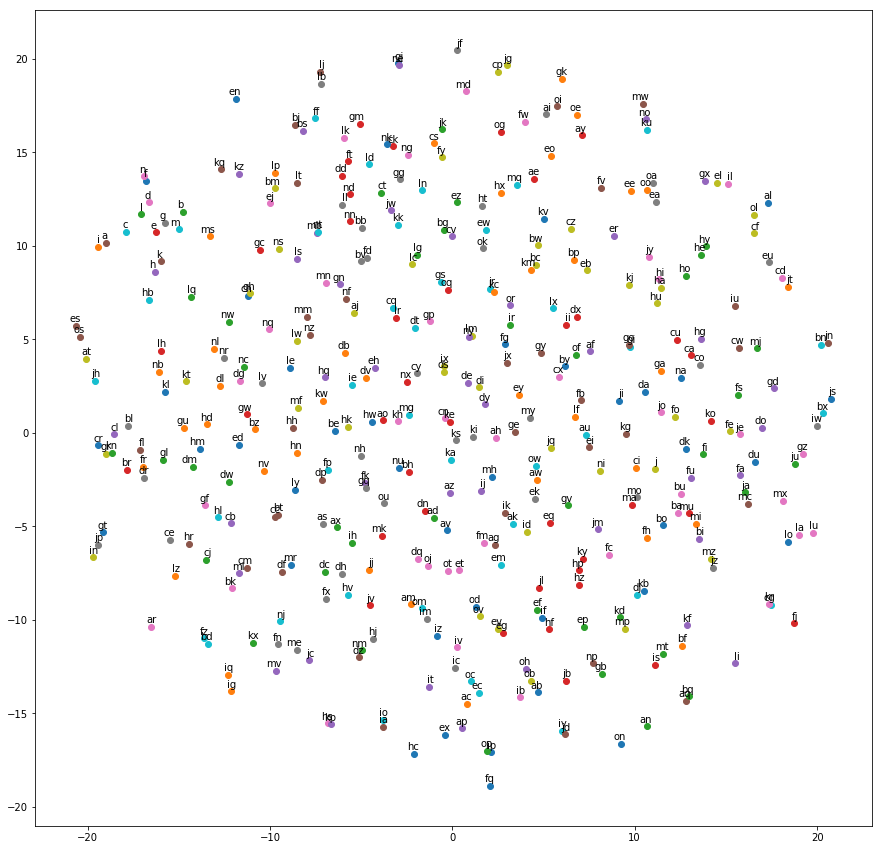

In [69]:
from sklearn.manifold import TSNE  
from matplotlib import pylab  
%matplotlib inline

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)  
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):  
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]  
plot(two_d_embeddings, words)  